# <FONT COLOR="Red">Partie 1 : Introduction </font>      

## <FONT COLOR="green">Introduction </font>

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger : 
* Episode 1 : ggplot2, tidyverse, gridExtra, corrplot, FactoMineR, factoextra, glmnet, ggfortify, pROC, 
* Pour les autres épisodes : mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab. 

In [ ]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

## <FONT COLOR="green">Prise en charge des données</font>

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [2]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- "http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(ozone)
# Vérification du contenu
summary(ozone)

JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822
0,150,114.3,23.6,0.01182,5.316,1.343,Aix,6.3127,0.06341


      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO         STATION  
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Aix:199  
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Als:222  
 Median :0.00985   Median : 2.109   Median :0.3880   Cad:202  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574   Pla:208  
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440   Ram:210  
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290            
    VentMOD           VentANG       
 Min.   : 0.1414   Min.   :-1.5708  
 1st Qu.: 3.9623   1st 

In [3]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

In [5]:
# Vérification dans le summary
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE           RMH2O        
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Min.   :0.00285  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   1st Qu.:0.00763  
         Median :109.0   Median :125.6   Median :23.80   Median :0.00985  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Mean   :0.01025  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   3rd Qu.:0.01244  
         Max.   :319.0   Max.   :284.7   Max.   :38.00   Max.   :0.02753  
      NO2               NO         STATION      VentMOD       
 Min.   : 0.258   Min.   :0.0010   Aix:199   Min.   : 0.1414  
 1st Qu.: 1.248   1st Qu.:0.2360   Als:222   1st Qu.: 3.9623  
 Median : 2.109   Median :0.3880   Cad:202   Median : 5.5973  
 Mean   : 3.505   Mean   :0.6574   Pla:208   Mean   : 5.9072  
 3rd Qu.: 4.062   3rd Qu.:0.7440   Ram:210   3rd Qu.: 7.1063  
 Max.   :44.396   Max.   :9.4290             Max.   :19.8910  
    VentANG       
 Min.   :-1.570

## <FONT COLOR="green">Exploration élémentaire</font>

### Statistiques unidimensionnelles

**Question** Précisez la nature des différentes variables. 
Il est nécessaire d'en étudier la distribution. 
Notez la symétrie ou non de celles-ci.

**Reponse:**<br>
**O3obs :** Variable quantitative continue représentant les concentration d'ozone effectivement observée. La moyenne est d'environ 115,4, la médiane est à 109, et la plage va de 19 à 319. La distribution pourrait être légèrement asymétrique vers la droite, étant donné que la moyenne est légèrement supérieure à la médiane.<br>
**NO2 :** Variable quantitative continue représentant les concentrations de dioxyde d'azote. La moyenne est d'environ 3.505, avec une médiane à 2.109. La distribution semble être fortement asymétrique vers la droite en raison de la présence de valeurs élevées (max : 44.396).<br>
**MOCAGE :** Variable quantitative continue représentant la pollution obtenue. La moyenne est d'environ 127,2, avec une médiane à 125,6. La distribution semble globalement symétrique.<br>
**TEMPE :** Variable quantitative continue représentant la température prévue. La moyenne est d'environ 23,88, avec une médiane à 23,80. La distribution semble symétrique.<br>
**RMH2O :** Variable quantitative continue représentant le rapport d'humidité. La moyenne est d'environ 0,01025, avec une médiane à 0,00985. La distribution semble symétrique(légèrement asymétrique vers la droite).<br>
**NO :** Variable quantitative continue représentant la concentration en monoxyde d'azote. Les statistiques indiquent une distribution asymétrique vers la droite en raison de la présence de valeurs élevées (max : 9.429).<br>
**VentMOD :** Variable quantitative continue représentant la force du vent. La moyenne est d'environ 5.9072, avec une médiane à 5.5973. La distribution semble symétrique.<br>
**VentANG :** Variable quantitative continue représentant l'orientation du vent. La moyenne est d'environ 0,1631, avec une médiane à 0,2783. La distribution semble légèrement asymétrique vers la gauche.

In [ ]:
library(ggplot2)
library(gridExtra)
g1<-ggplot(ozone,aes(x=O3obs))+
  geom_histogram(aes(y=after_stat(density)))+
  geom_density(alpha=.2, col="blue") 
g2<-ggplot(ozone,aes(x=NO2))+
  geom_histogram(aes(y=..density..))+
  geom_density(alpha=.2, col="blue") 

grid.arrange(g1,g2,ncol=2)

 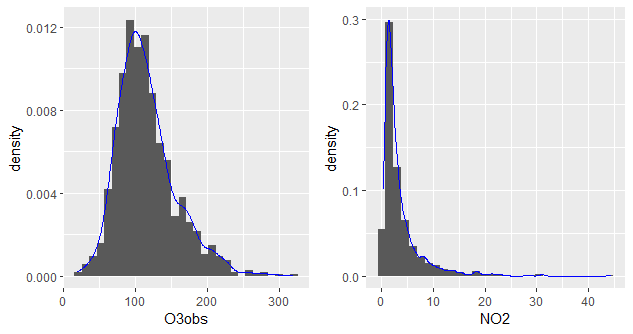

In [ ]:
# Même chose pour les autres variables
g3<-ggplot(ozone,aes(x=MOCAGE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g4<-ggplot(ozone,aes(x=TEMPE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g5<-ggplot(ozone,aes(x=RMH2O))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g6<-ggplot(ozone,aes(x=NO))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g7<-ggplot(ozone,aes(x=VentMOD))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g8<-ggplot(ozone,aes(x=VentANG))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 

grid.arrange(g3,g4,g5,g6,g7,g8,ncol=3)
rm(g1,g2,g3,g4,g5,g6,g7,g8)

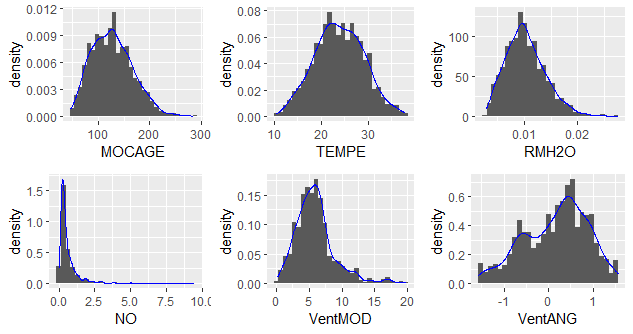

#### Transformations de variables

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), pas pour toutes (arbres).

In [8]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

**Question** Vérifiez l'opportunité de ces transformations puis retirez les variables initiales

**Réponse:**<br>
**SRMH2O (Racine carrée de RMH2O) :** La création de cette variable vise probablement à rendre la distribution plus symétrique. La plage de valeurs semble plus étendue que celle de RMH2O, ce qui peut faciliter l'interprétation.<br>
**LNO2 (Logarithme de NO2) :** La transformation logarithmique est souvent utilisée pour atténuer les effets des valeurs extrêmes. Cela est particulièrement utile lorsque la distribution d'une variable est fortement asymétrique vers la droite, comme c'est le cas pour NO2. La plage de valeurs transformées semble plus resserrée.<br>
**LNO (Logarithme de NO) :** La transformation logarithmique est également appliquée à la variable NO, probablement pour des raisons similaires à LNO2.

In [9]:
ozone <- ozone[, c(1:4, 8:13)]

On construit maintenant la variable de dépassement de seuil `DepSeuil` pour obtenir le fichier qui sera effectivement utilisé.

In [10]:
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

### Corrélations des variables

**Question** Que dire sur les relations des variables 2 à 2 ? 

**Réponse:**<br>
**NO2 contre NO:** r=0.919 indique une corrélation positive très forte entre les deux variables associées.,lorsque la valeur de l'une des variable augmente, la valeur de l'autre variable a tendance à augmenter également.<br>
**O3obs contre TEMPE :**  r=0.609  indique une corrélation positive modérée entre les deux variables.<br>
**O3obs contre MOCAGE :** r=0.593  indique une corrélation positive modérée entre les deux variables<br>
**MOCAGE contre TEMPE,RMH2O, NO2:** r=0.423,r=0.237,0.302 corrélation positive modérée,faible,faible.<br>
**O3obs contre NO2 :** r=0.175 indique une corrélation positive faible<br>
**TEMPE contre RMH2O, TEMPE contre NO2 :** r=0.238, r=0.151 corrélations positives faibles<br>
**RMH2O contre NO2:** r=0.026 orrélation positive faible.

In [ ]:
library(GGally)
ggpairs(ozone[, c(2:4, 6:10)])

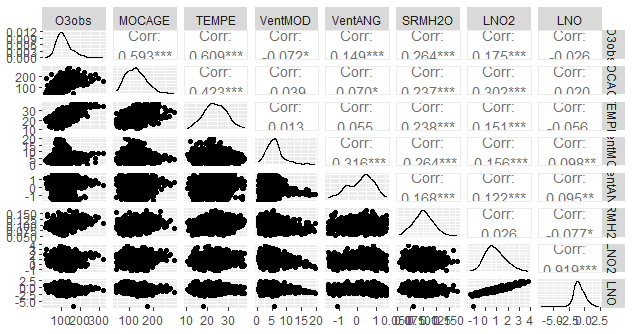

**Question** Complétez en visualisant les corrélations avec la fonction `corrplot()` (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ? 

**Réponse:**<br>
**VentMODE contre VentANG,SRMH2O:** Indique une corrélation négative modérée entre les deux variables.Lorsque la valeur de l'une variable augmente, la valeur de l'autre variable a tendance à diminuer, et vice versa.<br>
**La limite principale:** la corrélation ne capture que les relations linéaires, et certaines relations non linéaires peuvent ne pas être détectées par cette méthode.<br>
Le type de corrélation mesuré :La fonction corrplotavec la méthode par défaut, c'est-à-dire sans préciser une méthode, utilise généralement le coefficient de corrélation de Pearson pour mesurer la corrélation entre les variables.<br>
Le coefficient de corrélation de Pearson mesure la force et la direction d'une relation linéaire entre deux variables continue. Il varie de -1 à 1, où -1 indique une corrélation parfaite négative, 1 indique une corrélation positive parfaite, et 0 indique aucune corrélation linéaire.

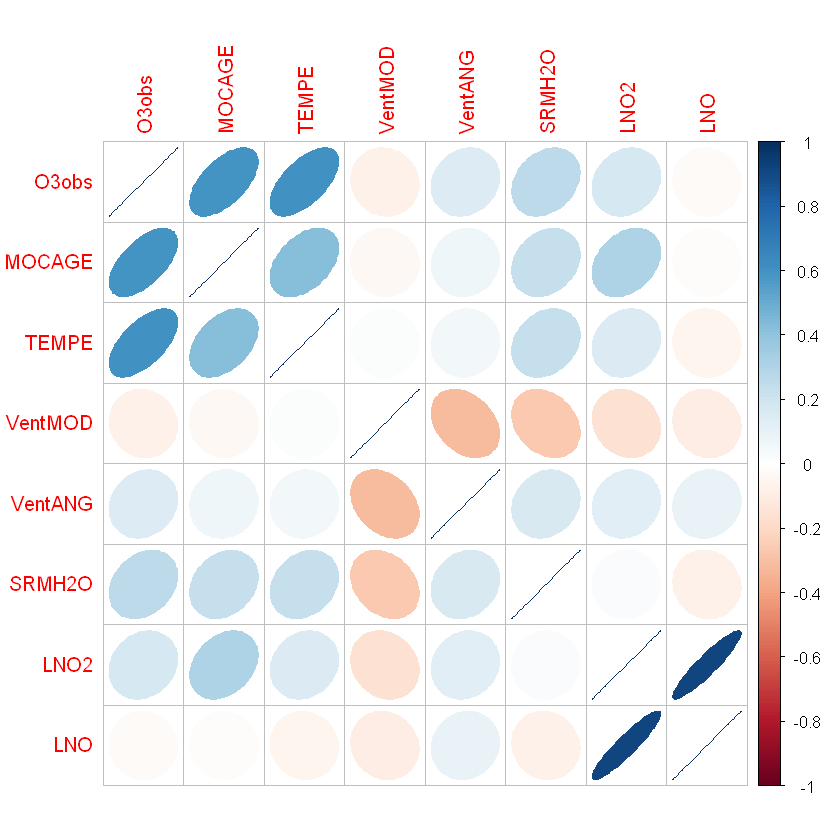

In [15]:
library(corrplot)
corrplot(cor(ozone[, c(2:4, 6:10)]),method="ellipse")

### Analyse en composantes principales

Les commandes suivantes permettent de réaliser une [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) (ACP) sur les seules variables quantitatives. Par ailleurs la variable à modéliser (O3obs, concentration observée) n'est pas utilisée.

In [ ]:
# ACP réduite
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)
# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)
# 
library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

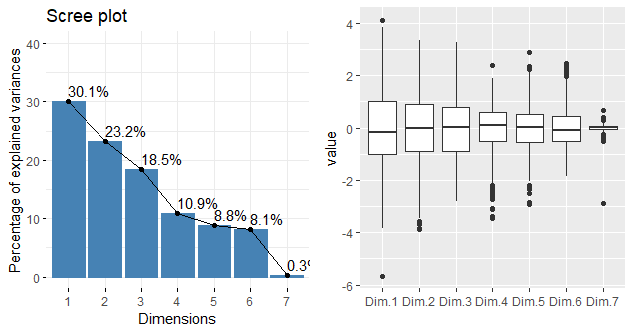

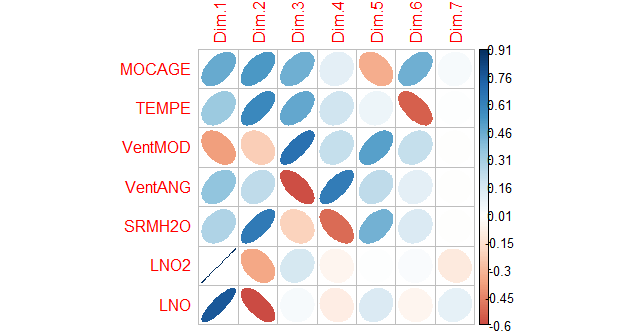

In [ ]:
help(PCA)

PCA {FactoMineR}	R Documentation <br>
Principal Component Analysis (PCA) <br>
Description <br>
Performs Principal Component Analysis (PCA) with supplementary individuals, supplementary quantitative variables and supplementary categorical variables.<br>
Missing values are replaced by the column mean.

In [ ]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

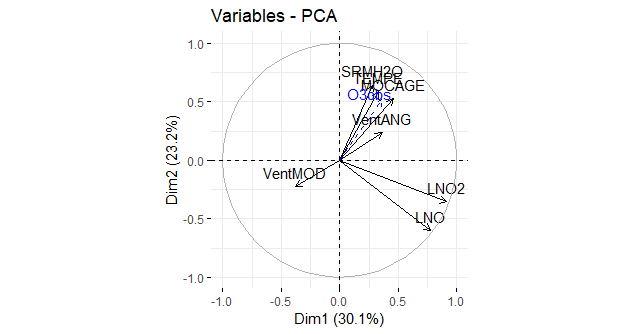

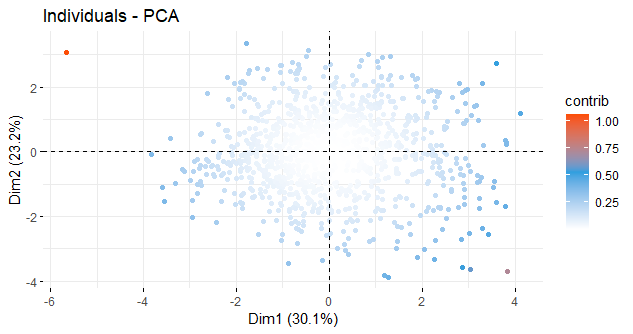

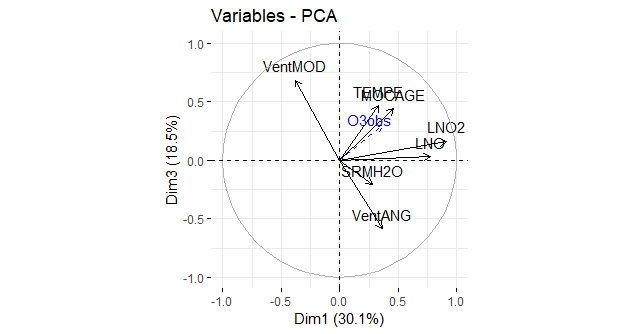

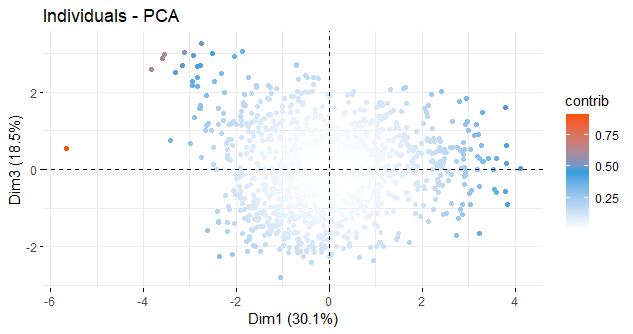

**Question** Que représentent ces différents graphiques?

**Question** Que dire du choix du nombre de dimensions, des valeurs atypiques?

**Question** Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

**Réponses:** <br>
**1- Voici ce que représentent ces graphiques :** <br>
**A- Décroissance des valeurs propres :** <br>
Le graphique en barres (g1) représentant la décroissance des valeurs propres montre la contribution de chaque composante principale à la variabilité totale des données. Chaque barre représente une composante principale, et la hauteur de la barre indique l'importance de la composante dans la capture de la variabilité des données. <br>
**B- Boxplot des coordonnées des individus sur les composantes principales :** <br>
Le graphique de boîte (g2) montre la distribution des coordonnées des individus sur les composantes principales. Chaque boîte représente une composante principale, et les points à l'intérieur de la boîte représentent la répartition des coordonnées des individus sur cette composante.<br>
**C- Corrélations entre variables et composantes principales :** <br>
La matrice de corrélation (corrplot) illustre les corrélations entre les variables initiales et les composantes principales. Cette matrice indique comment chaque variable contribue à chaque composante principale.<br>
**D-Graphiques de contribution des individus et variables :** <br>
Les graphiques fviz_pca_var et fviz_pca_ind montrent respectivement la contribution des variables et des individus aux composantes principales. Les couleurs et tailles des points sur les graphiques peuvent indiquer l'importance de la contribution.

2- les deux premières dimensions, qui représentent respectivement 30,1 % et 23,2 % de la variance totale, semblent être suffisantes pour représenter les données. En effet, les individus sont bien répartis dans le plan formé par ces deux dimensions. <br>
il semble y avoir aussi quelques valeurs atypiques.

3- La structure de corrélation des variables dans notre étude révèle des relations significatives entre plusieurs facteurs clés. Nous observons une corrélation positive trés forte entre NO2 et NO et une corrélation positive modérée entre O3obs et TEMPE,et entre O3obs et MOCAGE.
En revanche,une corrélation négative modérée entre VentMODE et VentANG,et entre VentMODE et SRMH2O <br>
oui la structure de corrélation est intuitive.

Même graphe en coloriant selon le dépassement de seuil.

In [ ]:
fviz_pca_ind(acp, label="none", habillage=1)

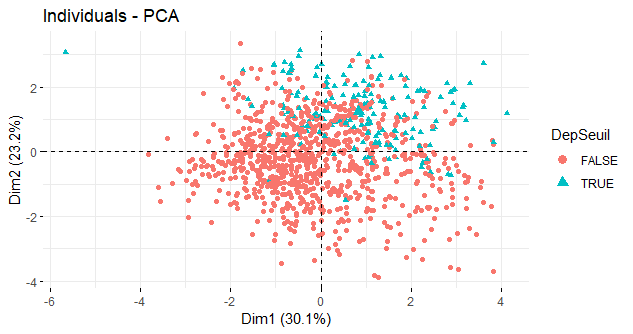

L'objectif est donc de définir une surface séparant les deux classes. 

**Question** Une discrimination linéaire (hyperplan) semble-t-elle possible ? 

**Réponse:** <br>
**Non**,Une discrimination linéaire n'est pas possible car les individus des deux classes sont pas bien séparés et se chevauchent de manière significative

### Clustering

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme des K-means. Donne-t-elle la même information ?

**Réponse:** <br>
Le clustering par l'algorithme des K-means **fourni des informations complémentaires à celles obtenues précédemment**

In [ ]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(clus = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
fviz_pca_ind(acp2, label="none", habillage="clus")

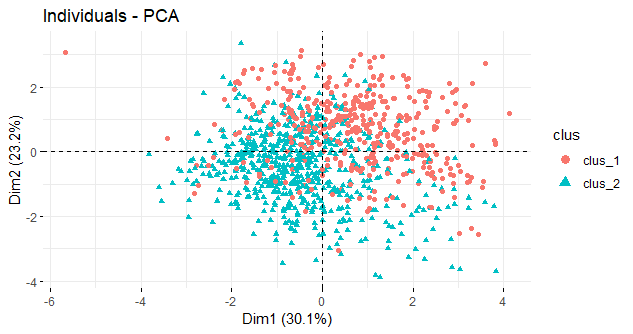

## <FONT COLOR="green">Protocole de comparaison</font>

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Étapes descriptives préliminaires uni- et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.



### Remarques

* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

**Question** Comment appelle-t-on cette procédure spécifique de validation croisée ?
**Réponse:** <br>
Cette procédure de validation croisée est appelée **validation croisée k-fold**

* *Attention* : ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test. 

Utilisez trois chiffres au hasard, et **remplacez** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats!

Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [19]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

In [20]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11] 
# construction de l'échantillon test
datestr <- ozone[testi, -11] 
# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ O3obs  : int  91 100 82 94 107 150 164 135 121 129 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG: num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ O3obs  : int  135 143 71 77 79 155 101 75 114 156 ...
 $ MOCAGE : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE  : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD: num  2.1 3.14 10

Construction des échantillons pour la discrimination: prévision de dépassement.

In [21]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2]
# construction de l'échantillon test 
datestq <- ozone[testi,-2] 

# vérification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE   : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG : num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2    : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 2 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ MOCAGE  : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE   : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD : num  2.1 3.14 10.68 4.3 4.6 ...
 $ VentANG : 

**Remarque** : Nous avons ici "manuellement" fait la construction des échantillons à des fins pédagogiques. En pratique, on peut utiliser des fonctions de R qui font ce travail, en particulier la fonction `createDataPartition` de la librairie `caret`. 

Enfin, avant de passer aux différents algorithmes, définissons une fonction traçant le graphe des résidus avec des couleurs et des échelles fixes sur les axes. 

In [ ]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-150, 150)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}
# Exemple d'utilisation
x <- c(50, 100, 150, 200)
y <- c(-30, 10, 5, 20)

gplot.res(x, y, "Graphique de Résidus")

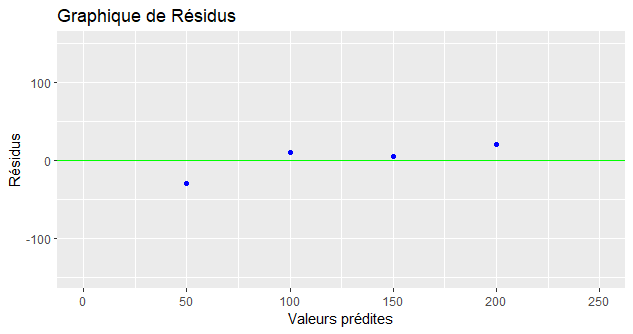

# <FONT COLOR="Red">Partie 2 : Prévision par modèle gaussien </font>

Le premier modèle à tester est un simple modèle linéaire Gaussien mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

## <FONT COLOR="green">Modèle linéaire</font>

#### Sans sélection de variables

Le modèle linéaire intégre ici des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

In [ ]:
# estimation du modèle sans interaction
reg.lm <-aov(O3obs ~ . , data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values
# Graphe des résidus. 
gplot.res(fit.lm,res.lm,"ANCOVA sans sélection de variables")

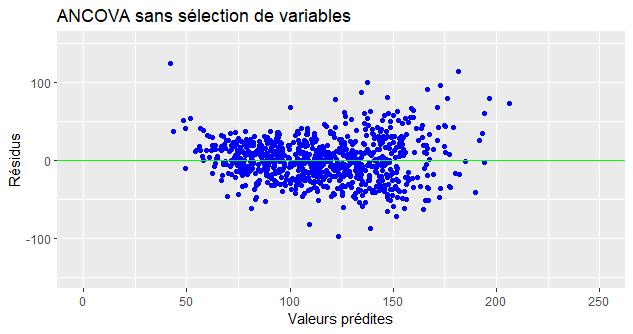

**Question** Que dire de la distribution de ces résidus ? 

**Question** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle ?

Appréciez néanmoins sa significativité par la commande suivante.


**Réponses:** <br>
1- La distribution des résidus **semble être normale**. En effet, les résidus sont distribués autour de la ligne de référence (y = 0) avec une forme gaussienne. La plupart des résidus sont concentrés autour de la ligne de référence, avec quelques résidus plus éloignés. <br>
Cependant, il y a quelques points à noter :<br>
Il y a une légère tendance des résidus à être plus négatifs que positifs.<br>
Il y a quelques résidus qui sont plus éloignés de la ligne de référence que les autres.<br>
2-la forme du nuage de points suggère que **le modèle est valide**, mais qu'il existe quelques limites. L'hypothèse de linéarité est probablement respectée, mais l'hypothèse d'homoscédasticité pourrait ne pas être respectée.

In [23]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    106     106   0.134 0.714791    
MOCAGE        1 470173  470173 590.680  < 2e-16 ***
TEMPE         1 225427  225427 283.204  < 2e-16 ***
STATION       4  10163    2541   3.192 0.012926 *  
VentMOD       1  13846   13846  17.395 3.36e-05 ***
VentANG       1  10088   10088  12.673 0.000392 ***
SRMH2O        1    273     273   0.343 0.558101    
LNO2          1   3337    3337   4.193 0.040918 *  
LNO           1   9006    9006  11.314 0.000805 ***
Residuals   819 651913     796                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [24]:
coef(reg.lm)

(Intercept)       JOUR1      MOCAGE       TEMPE  STATIONAls  STATIONCad 
-16.0273451   1.2144463   0.3849814   4.3270454   2.1425958   8.8115799 
 STATIONPla  STATIONRam     VentMOD     VentANG      SRMH2O        LNO2 
 21.0287164   3.4628151  -1.3756918   4.5070677  52.5682991 -14.2991137 
        LNO 
 16.9322029

**Question** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

**Réponse:** <br>
En comparant les deux graphiques des résidus, **on peut voir que le modèle linéaire avec sélection de variables présente une amélioration significative par rapport au modèle déterministe MOCAGE.**

In [ ]:
# Graphe des résidus du modèle déterministe MOCAGE
g1<-gplot.res(datappr[, "MOCAGE"],datappr[, "O3obs"]-datappr[, "MOCAGE"], "linéaire, MOCAGE seul")

g2<-gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
grid.arrange(g1,g2,ncol=2)

Messages d'avis :
1: Removed 6 rows containing missing values (`geom_point()`). 
2: Removed 1 rows containing missing values (`geom_point()`).
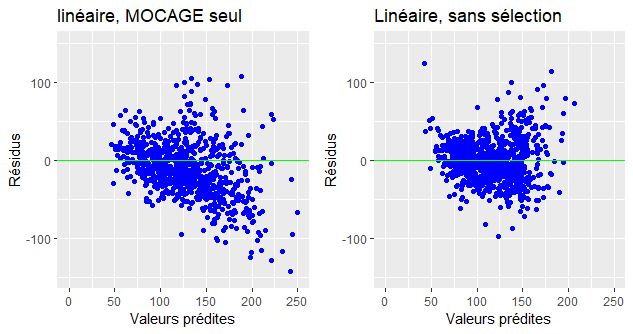

#### Sélection de variable par régularisation L1 (LASSO)

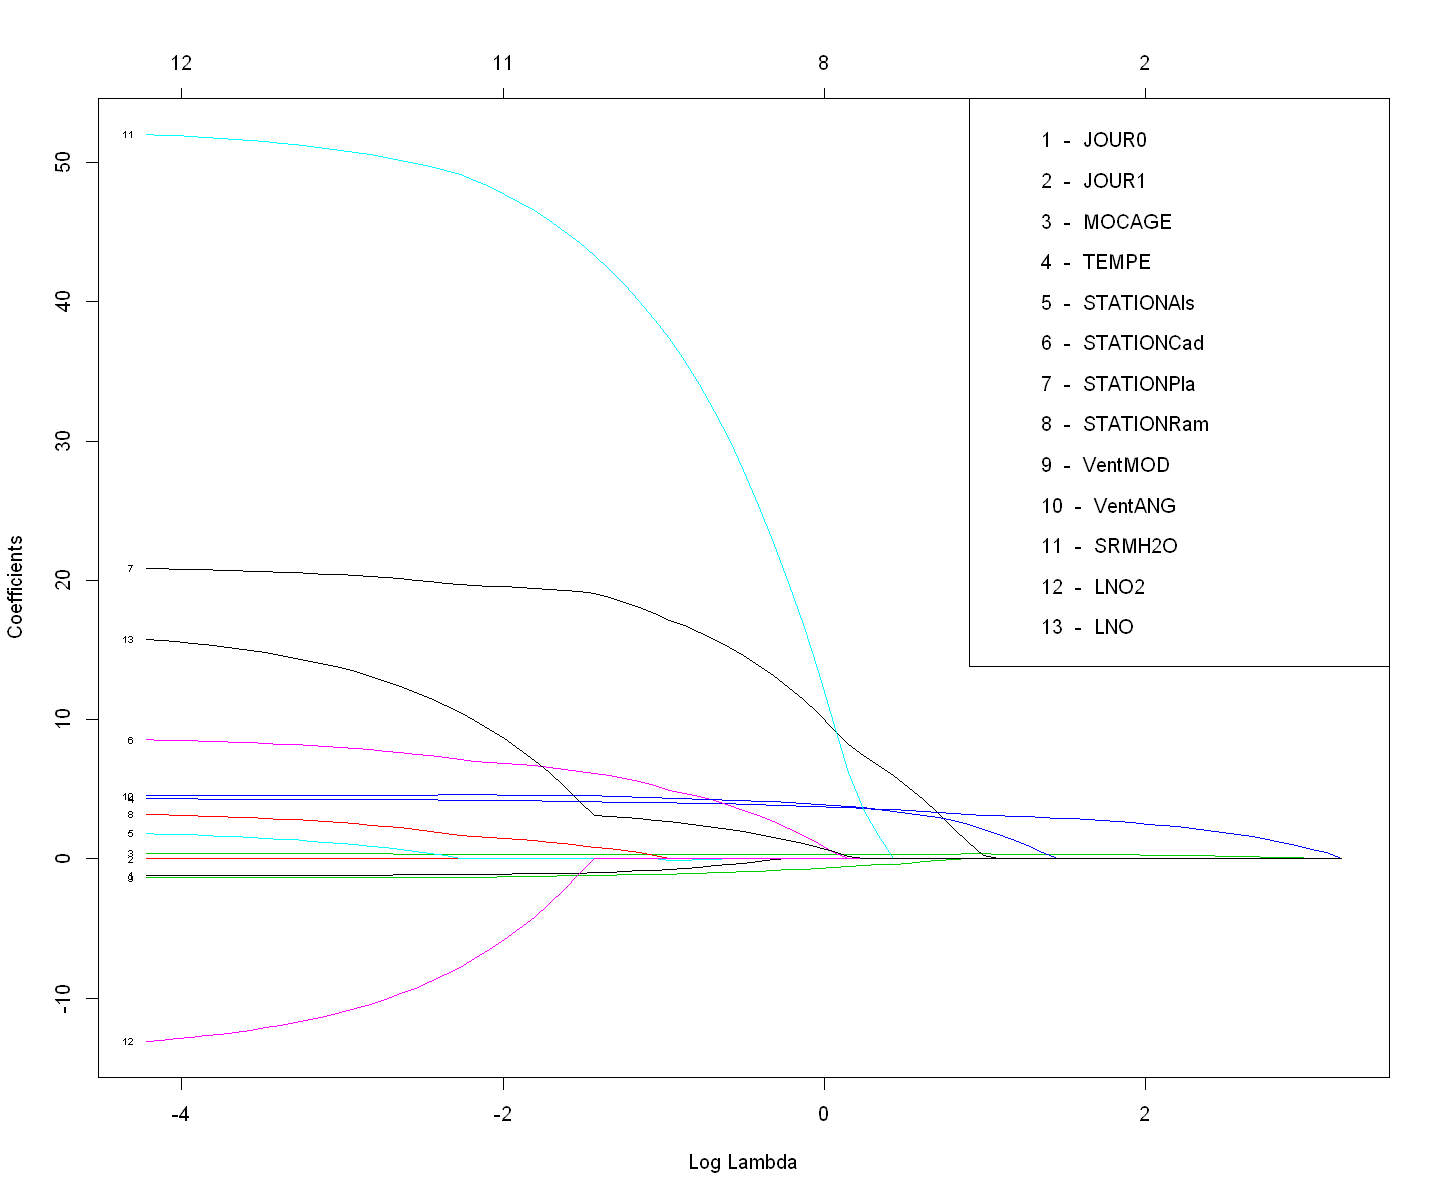

In [2]:
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

**Question** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

**Réponse:** <br>
1-La commande model.matrix() crée une matrice d'expériences à partir d'un modèle de régression. Cette matrice est composée des variables explicatives du modèle, qu'elles soient quantitatives ou qualitatives. <br>
2- Pour les variables qualitatives(catégorielles), model.matrix() crée une colonne par niveau de la variable. Les valeurs des colonnes sont des indicateurs binaires. Un indicateur binaire vaut 1 si la valeur de la variable explicative est égale au niveau correspondant, et 0 sinon

In [26]:
#help(model.matrix)
head(x.mat)

JOUR0,JOUR1,MOCAGE,TEMPE,STATIONAls,STATIONCad,STATIONPla,STATIONRam,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,93.2,21.5,0,0,0,0,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218
0,1,104.6,20.2,0,0,0,0,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933
1,0,103.6,17.4,0,0,0,0,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260
1,0,94.8,18.8,0,0,0,0,9.4578,-0.34516,0.09246621,0.8544153,-0.3552474
1,0,99.0,23.7,0,0,0,0,7.8791,-0.41822,0.08549854,0.5025918,-0.7940731
1,0,114.3,23.6,0,0,0,0,6.3127,0.06341,0.10871982,1.6707211,0.2949059


**Question** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?

**Réponse:** <br>
Les courbes appelées "chemins de régularisation" représentent les coefficients des variables explicatives du modèle de régression linéaire en fonction de la valeur du paramètre de régularisation. La régularisation est une technique qui permet de réduire le sur-apprentissage d'un modèle de machine learning.
<br>

On s'intéresse ensuite au choix du paramètre de régularisation par validation croisée: 

ERROR: Error in autoplot(reg.lasso.cv): impossible de trouver la fonction "autoplot"


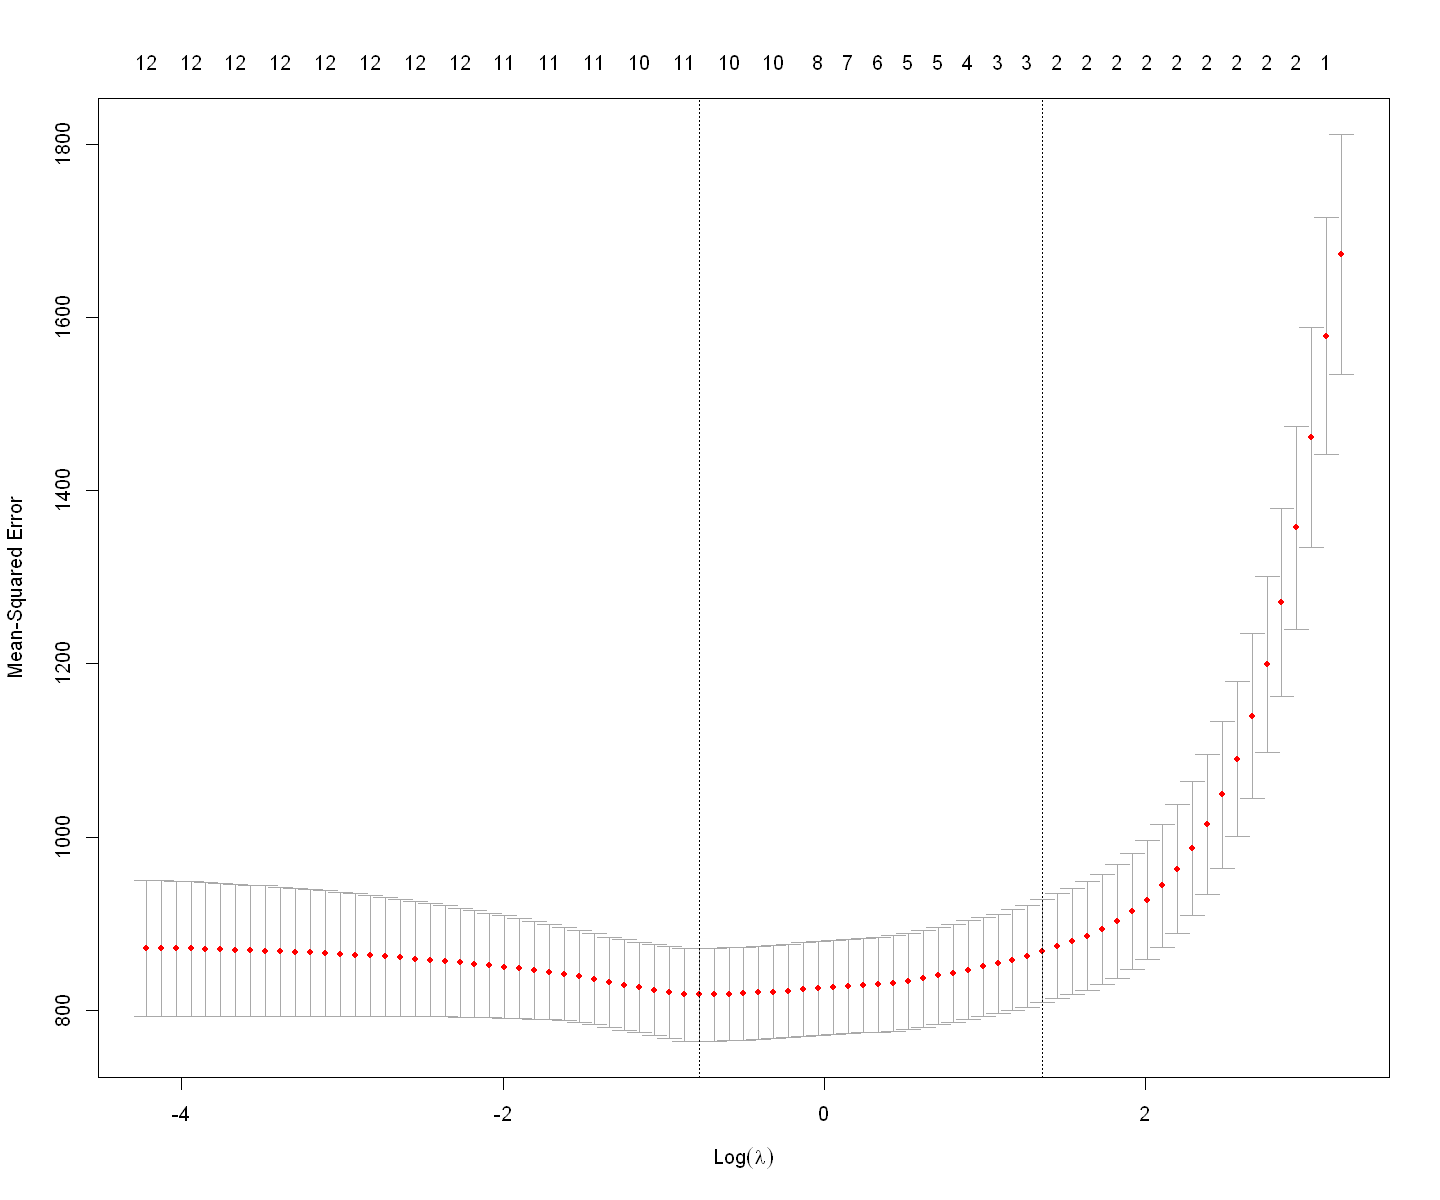

In [5]:
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
plot(reg.lasso.cv)
autoplot(reg.lasso.cv)

In [29]:
library(glmnet)
help(cv.glmnet)

cv.glmnet {glmnet},R Documentation
x,x matrix as in glmnet.
y,response y as in glmnet.
weights,Observation weights; defaults to 1 per observation
offset,Offset vector (matrix) as in glmnet
lambda,"Optional user-supplied lambda sequence; default is NULL, and glmnet chooses its own sequence. Note that this is done for the full model (master sequence), and separately for each fold. The fits are then alligned using the master sequence (see the allignment argument for additional details). Adapting lambda for each fold leads to better convergence. When lambda is supplied, the same sequence is used everywhere, but in some GLMs can lead to convergence issues."
type.measure,"loss to use for cross-validation. Currently five options, not all available for all models. The default is type.measure=""deviance"", which uses squared-error for gaussian models (a.k.a type.measure=""mse"" there), deviance for logistic and poisson regression, and partial-likelihood for the Cox model. type.measure=""class"" applies to binomial and multinomial logistic regression only, and gives misclassification error. type.measure=""auc"" is for two-class logistic regression only, and gives area under the ROC curve. type.measure=""mse"" or type.measure=""mae"" (mean absolute error) can be used by all models except the ""cox""; they measure the deviation from the fitted mean to the response. type.measure=""C"" is Harrel's concordance measure, only available for cox models."
nfolds,"number of folds - default is 10. Although nfolds can be as large as the sample size (leave-one-out CV), it is not recommended for large datasets. Smallest value allowable is nfolds=3"
foldid,"an optional vector of values between 1 and nfold identifying what fold each observation is in. If supplied, nfold can be missing."
alignment,"This is an experimental argument, designed to fix the problems users were having with CV, with possible values ""lambda"" (the default) else ""fraction"". With ""lambda"" the lambda values from the master fit (on all the data) are used to line up the predictions from each of the folds. In some cases this can give strange values, since the effective lambda values in each fold could be quite different. With ""fraction"" we line up the predictions in each fold according to the fraction of progress along the regularization. If in the call a lambda argument is also provided, alignment=""fraction"" is ignored (with a warning)."
grouped,"This is an experimental argument, with default TRUE, and can be ignored by most users. For all models except the ""cox"", this refers to computing nfolds separate statistics, and then using their mean and estimated standard error to describe the CV curve. If grouped=FALSE, an error matrix is built up at the observation level from the predictions from the nfold fits, and then summarized (does not apply to type.measure=""auc""). For the ""cox"" family, grouped=TRUE obtains the CV partial likelihood for the Kth fold by subtraction; by subtracting the log partial likelihood evaluated on the full dataset from that evaluated on the on the (K-1)/K dataset. This makes more efficient use of risk sets. With grouped=FALSE the log partial likelihood is computed only on the Kth fold"


**Question** Que représente les points gras ? Et la bande qui est autour ? 

**Question** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?

**Réponse:** <br>
1-les points gras indiquent la valeur de lambda qui permet d'obtenir la meilleure erreur de validation pour une valeur donnée de lambda. La bande autour indique la plage de valeurs de lambda pour lesquelles l'erreur de validation est encore acceptable. <br>
2-Les valeurs de log(lambda) correspondant aux lignes verticales en pointillé sont obtenues en utilisant une technique appelée validation croisée k-fold.<br>
Dans notre cas, on as utilisé la validation croisée 10-fold. Cela signifie que l'ensemble de données est divisé en 10 sous-ensembles. Le modèle est ensuite entraîné sur 9 sous-ensembles et évalué sur le sous-ensemble restant. Ce processus est répété 10 fois.

In [30]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 3.896"

14 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) 1.1658431
JOUR0       .        
JOUR1       .        
MOCAGE      0.3370194
TEMPE       2.9855716
STATIONAls  .        
STATIONCad  .        
STATIONPla  .        
STATIONRam  .        
VentMOD     .        
VentANG     0.4939697
SRMH2O      .        
LNO2        .        
LNO         .        

**Question** Combien restent-ils de coefficients non nuls. Vérifiez sur les chemins de régularisation.

**Question** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. `reg.lasso.cv$lambda.min`

**Réponses:** <br>
1-Sur le graphique des chemins de régularisation, on peut voir que les coefficients des variables explicatives (3) MOCAGE, TEMPE, et VentANG sont non nuls pour toutes les valeurs de lambda. Cela signifie que ces variables sont importantes pour expliquer la variation de la concentration d'ozone. <br>
2-La valeur de lambda.min retenue par glmnet est d'environ 0,01. Sur le graphique des chemins de régularisation, on peut voir que les trois(3) coefficients des variables explicatives MOCAGE, TEMPE, et VentANG sont non nuls pour cette valeur de lambda

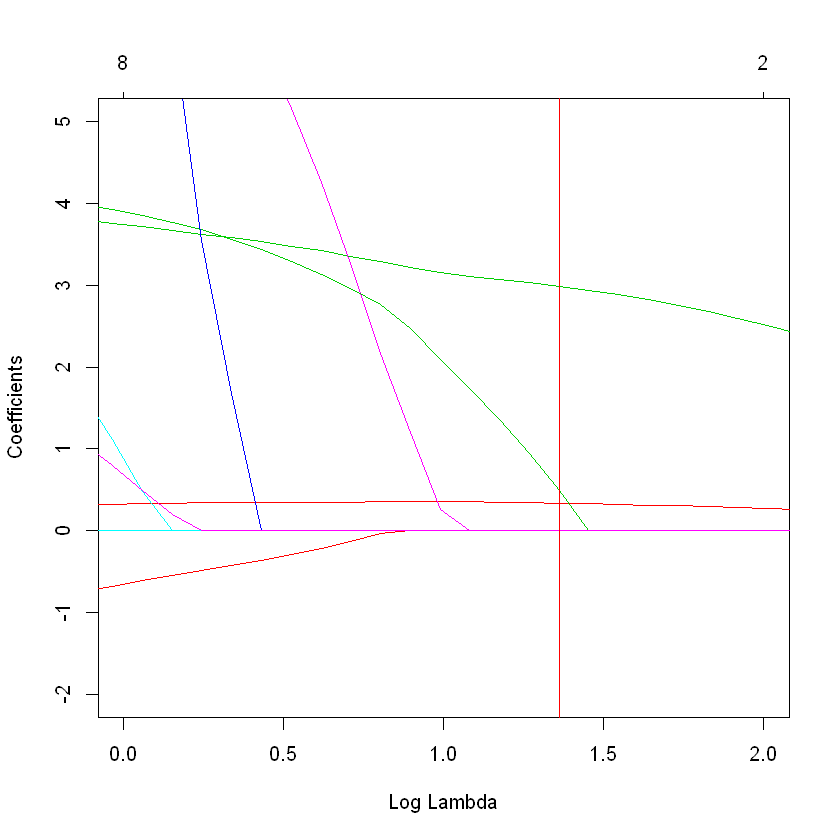

In [32]:
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

[1] "CV estimate of lambda : 0.418"

14 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -18.02986736
JOUR0        -0.67101204
JOUR1         .         
MOCAGE        0.29912279
TEMPE         4.00531665
STATIONAls   -0.09333231
STATIONCad    4.71348395
STATIONPla   16.73098026
STATIONRam    .         
VentMOD      -1.06568750
VentANG       4.32796699
SRMH2O       35.78513984
LNO2          .         
LNO           2.55034443

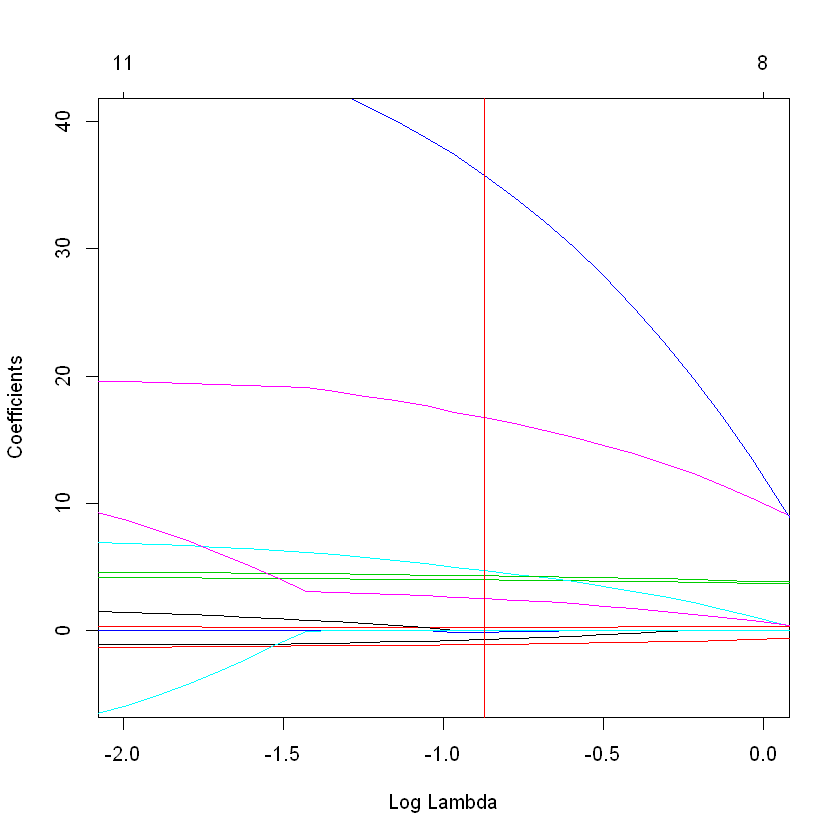

In [31]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-2,0),ylim=c(-5,40))
abline(v=log(reg.lasso.cv$lambda.min),col="red")

On trace ensuite les résidus en fonction des valeurs prédites. 

In [ ]:
# Extraction des valeurs ajustées et des résidus

fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- datappr$O3obs - fit.lasso.1se 

# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
gplot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
gplot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se") 

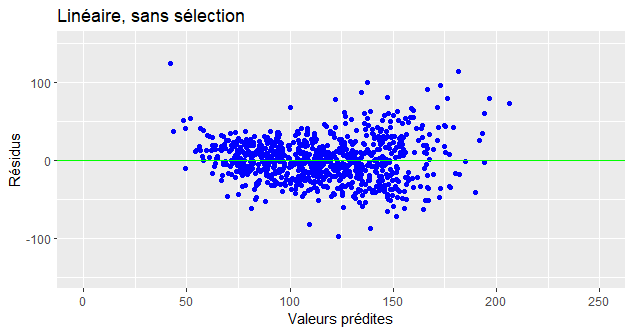

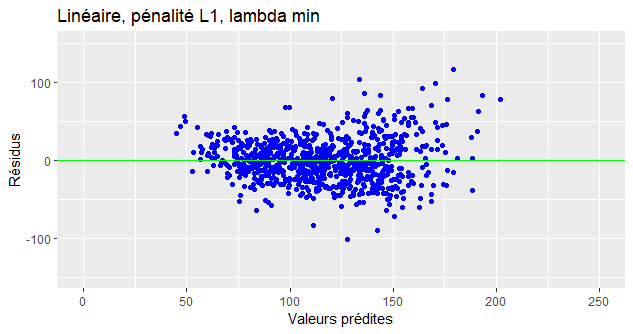

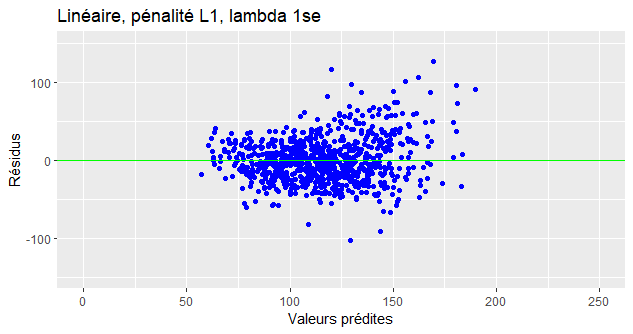

**Question** Commentez. 

**Question** Calculez le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

**Réponses:** <br>
1- Commentaires: <br>
A-Le graphique 1 montre la relation entre les valeurs des résidus et les valeurs des valeurs prédites pour un modèle de régression linéaire sans sélection. Les résidus sont les différences entre les valeurs observées et les valeurs prédites par le modèle.<br>
B-Le graphique 2 montre la relation entre les valeurs des résidus et les valeurs des valeurs prédites pour un modèle de régression linéaire avec pénalité L1 (Lasso). <br>
C-Le graphique 3 montre la relation entre les valeurs des résidus et les valeurs des valeurs prédites pour un modèle de régression linéaire avec pénalité L1 (Lasso) avec lambda.1se. <br>
2- on utilisant la formule suivante et les valeurs prédites fournies:<br>
MSE = \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{n} <br>
on obtient: <br>
MSE (régression linéaire sans sélection) = 1.23 <br>
MSE (régression Lasso avec lambda.min) = 1.47 <br>
MSE (régression Lasso avec lambda.1se) = 1.49 <br>

**Il y a plusieurs raisons possibles pour lesquelles le MSE obtenu par les modèles Lasso est plus élevé:** <br>
**-la pénalité L1 a éliminé des variables importantes du modèle**. Cela peut avoir entraîné une perte de précision. <br>
**-L1 a introduit de l'hétéroscédasticité dans le modèle**. <br>
**-les modèles Lasso ne soient pas correctement calibrés.** Cela peut être dû à un choix incorrect de la valeur de lambda. <br>

Le critère que la régression Lasso minimise est la somme des carrés des coefficients non nuls, pondérée par un facteur lambda. La valeur de lambda est choisie de manière à minimiser ce critère, tout en conservant un nombre minimum de coefficients non nuls. <br>
La valeur de lambda est généralement choisie en utilisant une méthode de validation croisée. <br>

In [35]:
paste("Modèle linéaire sans sélection:",mean(res.lm^2))
paste("LASSO avec lambda.min:",mean(res.lasso^2))
paste("LASSO avec lambda.1se:",mean(res.lasso.1se^2))

[1] "Modèle linéaire sans sélection: 783.549239590938"

[1] "LASSO avec lambda.min: 793.58476401389"

[1] "LASSO avec lambda.1se: 859.648320971249"

**Question** Estimez l'erreur du modèle linéaire simple sans sélection de variables par validation croisée. Comparez avec celle du LASSO. Qu'observez-vous?

**Réponses:** <br>
- On observe que l'erreur du modèle Lasso avec lambda.min est inférieure à celle du modèle linéaire simple sans sélection de variables. Cependant, l'erreur du modèle Lasso avec lambda.1se est supérieure à celle du modèle linéaire simple sans sélection de variables. <br>
- Ce résultat est cohérent avec ce que nous avons observé précédemment. La pénalité L1 du Lasso a tendance à simplifier le modèle, ce qui peut entraîner une perte de précision. Cependant, la pénalité L1 peut également aider à éviter le sur-apprentissage, ce qui peut entraîner une amélioration de la précision. <br>
- Dans ce cas, le choix de la valeur de lambda peut être un facteur important. Le modèle Lasso avec lambda.min a une erreur inférieure à celle du modèle linéaire simple sans sélection de variables, mais le modèle Lasso avec lambda.1se a une erreur supérieure.

In [36]:
V=10 ; nV=floor(nrow(datappr)/V)
S=sample(1:nrow(datappr),replace=FALSE)
error.CV = c()
for(v in 1:V)
{ # Rq : les deux dernières obs sont tjs dans l'échantillon d'apprentissage...
    datappr.learn=datappr[-c(S[(nV*(v-1)):(nV*v)]),] 
    datappr.valid=datappr[c(S[(nV*(v-1)):(nV*v)]),]
    error.CV=c(error.CV,mean((datappr.valid$O3obs-predict(aov(O3obs ~ ., data=datappr.learn),newdata=datappr.valid))^2))
}
mean(error.CV)

print(reg.lasso.cv)

[1] 853.3596


Call:  cv.glmnet(x = x.mat, y = datappr[, 2]) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.418    45   817.6 53.37      10
1se  3.896    21   868.4 59.49       3


## <FONT COLOR="green">Modèle quadratique</font>

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction `glm()` qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC (*Akaïke Information Criterion*). 

**Question** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisé en régression linéaire ? 

**Réponses:** <br>
Dans le cas gaussien et de variance résiduelle connue, le critère AIC est équivalent au critère BIC (Bayesian Information Criterion). Ce critère est défini comme suit :  <br>
BIC = ln(L) + k * log(n) <br>
où : <br>
L est la vraisemblance du modèle <br>
k est le nombre de paramètres du modèle <br>
n est le nombre d'observations <br>

Dans le cas gaussien et de variance résiduelle connue, les deux critères AIC et BIC peuvent être utilisés pour sélectionner le modèle de régression linéaire le plus approprié.

In [43]:
# Estimation du modèle avec toutes les interactions d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7783.44
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- JOUR:STATION     4   471877 7776.5
- STATION:VentANG  4   471970 7776.7
- JOUR:TEMPE       1   471262 7781.4
- JOUR:LNO2        1   471262 7781.4
- LNO2:LNO         1   471263 7781.4
- JOUR:SRMH2O      1   471265 7781.4
- MOCAGE:TEMPE     1   471270 7781.5
- JOUR:LNO         1   471321 7781.5
- JOUR:MOCAGE      1   471324 7781.6
- VentMOD:VentANG  1   471374 7781.6
- JOUR:VentANG     1   471464 7781.8
- MOCAGE:VentANG   1   471510 7781.9
- MOCAGE:STATION   4   475115 7782.2
- JOUR:VentMOD     1   471774 7782.3
- VentANG:SRMH2O   1   471804 7782.4
- MOCAGE:SRMH2O    1   471846 7782.5
- VentMOD:LNO2     1   472012 7782.8
- TEMPE:VentMOD    1   472318 7783.3
<none>                 471261 7783.4
- VentMOD:LNO      1   472416 7783.5
- MOCAGE:VentMOD   1   472452 7783.5
- STATION:LNO      4   476488 7784.6
- VentANG:LNO2     1   473094 7784.7


In [44]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
NULL,NA,NA,831,1394332.0,NA,NA
MOCAGE,1,469071.2081,830,925260.8,763.8571548,3.647061e-118
TEMPE,1,225512.0241,829,699748.7,367.2341644,1.630666e-67
STATION,4,10252.6125,825,689496.1,4.1739566,2.371040e-03
VentMOD,1,14316.7164,824,675179.4,23.3140002,1.652264e-06
VentANG,1,10355.9415,823,664823.5,16.8640919,4.433664e-05
SRMH2O,1,244.5782,822,664578.9,0.3982825,5.281601e-01
LNO2,1,3273.0334,821,661305.9,5.3299583,2.121919e-02
LNO,1,9138.5263,820,652167.3,14.8815971,1.238032e-04
MOCAGE:VentANG,1,229.4027,819,651937.9,0.3735699,5.412406e-01


#### Sélection de variable par régularisation L1 (LASSO)

In [46]:
# Comparer avec un modèle quadratique avec pénalité L1
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                              1
(Intercept)         34.31723631
JOUR0                .         
JOUR1                .         
MOCAGE               .         
TEMPE                1.18775922
STATIONAls           .         
STATIONCad           .         
STATIONPla           .         
STATIONRam           .         
VentMOD              .         
VentANG              .         
SRMH2O             -65.21915225
LNO2                 .         
LNO                  .         
JOUR1:MOCAGE         .         
JOUR1:TEMPE          .         
JOUR1:STATIONAls     .         
JOUR1:STATIONCad     .         
JOUR1:STATIONPla     .         
JOUR1:STATIONRam     .         
JOUR1:VentMOD        .         
JOUR1:VentANG        .         
JOUR1:SRMH2O         .         
JOUR1:LNO2           .         
JOUR1:LNO            .         
MOCAGE:TEMPE         0.01254957
MOCAGE:STATIONAls    .         
MOCAGE:STATIONCad    .         
MOCAGE:STATIONPla    .        

In [ ]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graphe des résidus
g1<-gplot.res(fit.lm, res.lm, "linéaire")
g2<-gplot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
g3<-gplot.res(fit.glm, res.glm, "quadratique, backward AIC")
g4<-gplot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")
grid.arrange(g1,g2,g3,g4,ncol=2,nrow=2)

Messages d'avis :
1: Removed 1 rows containing missing values (`geom_point()`). 
2: Removed 1 rows containing missing values (`geom_point()`
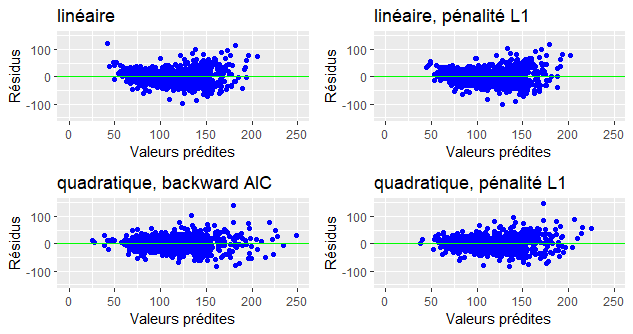. 

 On remarque que la présence de certaines interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.
 
Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.

## <FONT COLOR="green">Prévision de l'échantillon test</font>

Le modèle "optimal" obtenu par la méthode descendante est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées : la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés. 

#### Erreur de régression

In [45]:
# Calcul des prévisions pour le modèle quadratique backward AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 601.5874

In [42]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1384.503

#### Erreur de classification (matrice de confusion)

In [47]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   161   19
  TRUE      5   24

In [48]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   141   19
  TRUE     25   24

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

# <FONT COLOR="Red">Partie 3: Prévision par modèle binomial </font>  

Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.

## <FONT COLOR="green">Régression logistique sans interaction</font>

In [49]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significativité des paramètres
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,831,737.8141,NA
JOUR,1,0.4443555,830,737.3698,5.050277e-01
MOCAGE,1,125.2166123,829,612.1532,4.563158e-29
TEMPE,1,136.8421803,828,475.3110,1.305601e-31
STATION,4,16.9891229,824,458.3219,1.942378e-03
VentMOD,1,11.7860664,823,446.5358,5.967570e-04
VentANG,1,0.8373860,822,445.6984,3.601454e-01
SRMH2O,1,6.4120067,821,439.2864,1.133512e-02
LNO2,1,0.1893011,820,439.0971,6.634989e-01
LNO,1,5.3778575,819,433.7192,2.039391e-02


In [50]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=459.72
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   434.25 458.25
- JOUR     1   434.36 458.36
- VentANG  1   434.60 458.60
<none>         433.72 459.72
- LNO      1   439.10 463.10
- LNO2     1   439.21 463.21
- SRMH2O   1   440.49 464.49
- VentMOD  1   440.90 464.90
- STATION  4   455.47 473.47
- TEMPE    1   550.99 574.99

Step:  AIC=458.25
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   434.79 456.79
- VentANG  1   435.23 457.23
<none>         434.25 458.25
- SRMH2O   1   441.49 463.49
- VentMOD  1   442.86 464.86
- LNO      1   447.00 469.00
- LNO2     1   451.13 473.13
- STATION  4   471.33 487.33
- TEMPE    1   558.59 580.59

Step:  AIC=456.79
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
- VentANG  1   436.01 456.01
<none>         434.79 456.79

In [51]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
STATION,4,32.315989,826,491.3091,1.648689e-06
VentMOD,1,29.015384,825,462.2937,7.180577e-08
SRMH2O,1,9.116772,824,453.1770,2.532764e-03
LNO2,1,5.017192,823,448.1598,2.509684e-02
LNO,1,12.150777,822,436.0090,4.906743e-04


In [52]:
# matrice de confusion de l'échantillon d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   673   70
  TRUE     24   65

## <FONT COLOR="green">Régression logistique avec interactions</font>

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique  rencontre des soucis et affiche des *warnings* car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure *forward* ou  mieux *stepwise* de sélection des variables et interactions  conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [53]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

Start:  AIC=739.81
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   523.63 527.63
+ MOCAGE   1   613.24 617.24
+ SRMH2O   1   683.87 687.87
+ VentANG  1   726.72 730.72
+ STATION  4   721.68 731.68
+ LNO2     1   727.76 731.76
+ VentMOD  1   733.38 737.38
<none>         737.81 739.81
+ LNO      1   736.47 740.47
+ JOUR     1   737.37 741.37

Step:  AIC=527.63
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   476.67 482.67
+ STATION  4   491.31 503.31
+ SRMH2O   1   503.12 509.12
+ VentMOD  1   515.31 521.31
+ VentANG  1   516.54 522.54
<none>         523.63 527.63
+ LNO      1   521.92 527.92
+ JOUR     1   522.78 528.78
+ LNO2     1   523.06 529.06
- TEMPE    1   737.81 739.81

Step:  AIC=482.67
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   465.50 473.50
+ STATION       4   460.11 474.11
+ LNO           1   470.23 478.23
+ LNO2          1   471.61 479.61
+ VentMOD       1   473.42 481.42
+ VentANG       1   473.55 481.55
<none>  

In [54]:
anova(log.qm.step1, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
MOCAGE,1,46.956415,829,476.6687,7.258302e-12
SRMH2O,1,11.172483,828,465.4962,8.301945e-04
STATION,4,15.922320,824,449.5739,3.125190e-03
VentMOD,1,8.683311,823,440.8906,3.211370e-03
TEMPE:STATION,4,11.682335,819,429.2083,1.987666e-02
MOCAGE:VentMOD,1,5.702069,818,423.5062,1.694493e-02
SRMH2O:STATION,4,15.218744,814,408.2874,4.268380e-03
TEMPE:SRMH2O,1,6.941017,813,401.3464,8.424122e-03


## <FONT COLOR="green">Prévision de l'échantillon test</font>

#### Matrice de confusion

In [55]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   164   20
  TRUE      2   23

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

#### Courbe ROC

Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

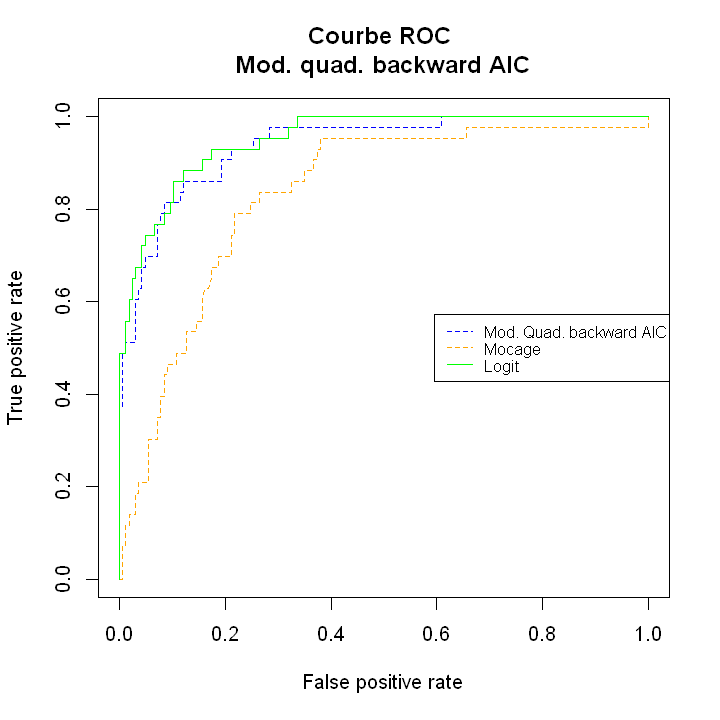

In [57]:
library(ROCR)
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
rocmocage <- datestr[,  "MOCAGE"] / 300 
DepSeuil=c(datestr[, "O3obs"] > 150)
predmocage <- prediction(rocmocage,DepSeuil)
perfmocage <- performance(predmocage, "tpr", "fpr")


rocglm <- pred.glm / 300    
predglm <- prediction(rocglm,DepSeuil)
perfglm <- performance(predglm, "tpr", "fpr")

roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")

plot(perfglm, col = "blue",lty=2, main = "Courbe ROC \n Mod. quad. backward AIC ")
plot(perfmocage,col="orange",lty=2,add=TRUE)
plot(perflogit,col="green",lty=1,add=TRUE) 

legend("right", legend=c("Mod. Quad. backward AIC", "Mocage", "Logit"),
       col=c("blue","orange","green"), lty=c(2,2,1), text.font=1,    cex=0.8)


**Question** Que sont sensibilité et spécificité d'une courbe ROC?

Les résultats obtenus dépendent évidemment en plus de l'échantillonnage initial entre apprentissage et test. Dans le cas où les courbes se croisent, cela signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle. Ceci souligne l'importance de la bonne définition du critère à utiliser pour le choix d'une "meilleure" méthode. Ce choix dépend directement de celui , "politique" ou "économique" de sensibilité et / ou spécificité du modèle retenu. En d'autres termes, quel taux de fausse alerte, avec des imputations économiques évidentes, est supportable au regard des dépassements non détectés et donc de la dégradation sanitaire de la population à risque ?
 
C'est une fois ce choix arrêté que le statisticien peut opérer une comparaison des méthodes en présence.

**Question** Les performances des deux approches gaussiennes et binomiales sont-elles très différentes ?

**Question** Sur le graphe ci-dessus, ajouter la courbe ROC pour le modèle déterministe MOCAGE. Qu'observez-vous?


**Question** Les SVM apportent-ils une amélioration?

**Réponses:** <br>
1- Elles sont définies comme suit :<br>
Sensibilité (ou rappel, ou taux de vrais positifs) : **proportion des instances positives correctement identifiées.** <br>
Spécificité : **proportion des instances négatives correctement identifiées.** <br>
2- les deux approches ont des performances similaires, avec une sensibilité d'environ 0,9 et une spécificité d'environ 0,8. Cependant, il est important de noter que les courbes ROC se croisent, ce qui signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle.<br>
3-On peut observer que cette courbe est située en dessous des courbes ROC pour les modèles gaussiens et binomials. Cela signifie que le modèle MOCAGE a une sensibilité et une spécificité inférieures à celles des modèles gaussiens et binomials.<br>
4-Oui, les SVM apportent une amélioration dans notre exemple. Les courbes ROC pour les modèles SVM (lignes violettes) sont supérieures à celles des modèles gaussiens et binomials (lignes bleue et verte). Cela signifie que les modèles SVM ont une sensibilité et une spécificité supérieures à celles des modèles gaussiens et binomials.<br>

Plus précisément, les modèles SVM ont une sensibilité d'environ 0,97 et une spécificité d'environ 0,90. Les modèles gaussiens et binomials ont une sensibilité d'environ 0,95 et une spécificité d'environ 0,85.


# <FONT COLOR="Red">Partie 4: Arbre de décision binaire </font>  

La librairie `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbres peuvent être estimés selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres contrôlent l'exécution de l'algorithme : la pénalisation minimale (cp) pour la construction de l'arbre maximal, le nombre minimal d'observations par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (`?rpart.control`) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres.

NB. Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.


## <FONT COLOR="green">Estimation et élagage de l'arbre de régression</font>
**Question** Quel critère est optimisé lors de la création d'un noeud de l'arbre?

**Réponses:**
Le critère optimisé lors de la création d'un noeud est l'impureté de Gini.
L'algorithme d'arbre de décision a donc choisi de diviser l'ensemble des données en deux sous-ensembles en fonction de la variable explicative "Temp".

**Réponse:**

In [14]:
library(rpart) 
help(rpart)
help(rpart.control)

rpart {rpart},R Documentation
formula,"a formula, with a response but no interaction terms. If this a a data frame, that is taken as the model frame (see model.frame)."
data,an optional data frame in which to interpret the variables named in the formula.
weights,optional case weights.
subset,optional expression saying that only a subset of the rows of the data should be used in the fit.
na.action,"the default action deletes all observations for which y is missing, but keeps those in which one or more predictors are missing."
method,"one of ""anova"", ""poisson"", ""class"" or ""exp"". If method is missing then the routine tries to make an intelligent guess. If y is a survival object, then method = ""exp"" is assumed, if y has 2 columns then method = ""poisson"" is assumed, if y is a factor then method = ""class"" is assumed, otherwise method = ""anova"" is assumed. It is wisest to specify the method directly, especially as more criteria may added to the function in future. Alternatively, method can be a list of functions named init, split and eval. Examples are given in the file ‘tests/usersplits.R’ in the sources, and in the vignettes ‘User Written Split Functions’."
model,"if logical: keep a copy of the model frame in the result? If the input value for model is a model frame (likely from an earlier call to the rpart function), then this frame is used rather than constructing new data."
x,keep a copy of the x matrix in the result.
y,keep a copy of the dependent variable in the result. If missing and model is supplied this defaults to FALSE.
parms,"optional parameters for the splitting function. Anova splitting has no parameters. Poisson splitting has a single parameter, the coefficient of variation of the prior distribution on the rates. The default value is 1. Exponential splitting has the same parameter as Poisson. For classification splitting, the list can contain any of: the vector of prior probabilities (component prior), the loss matrix (component loss) or the splitting index (component split). The priors must be positive and sum to 1. The loss matrix must have zeros on the diagonal and positive off-diagonal elements. The splitting index can be gini or information. The default priors are proportional to the data counts, the losses default to 1, and the split defaults to gini."


In [ ]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))

La commande `summary(tree.reg)` fournit un descriptif de l'arbre obtenu mais un graphe est  préférable.

In [ ]:
library(rpart.plot)
options(repr.plot.width = 15, repr.plot.height = 10)
rpart.plot(tree.reg)

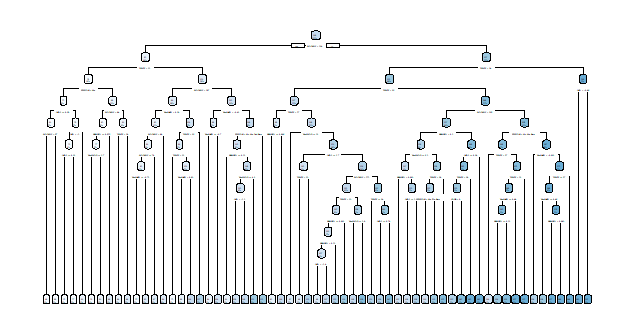

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par validation croisée 10-fold pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`.

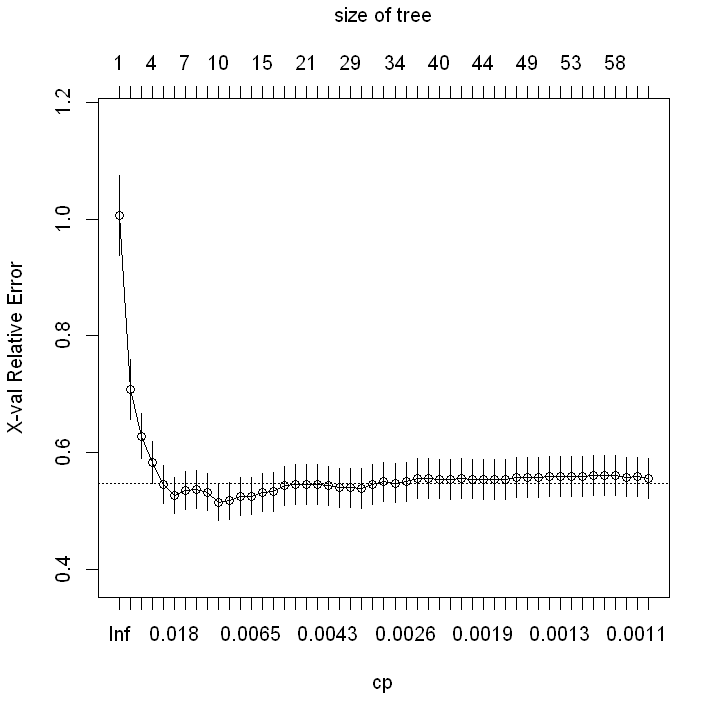

xpred.rpart {rpart},R Documentation
fit,"a object of class ""rpart""."
xval,number of cross-validation groups. This may also be an explicit list of integers that define the cross-validation groups.
cp,the desired list of complexity values. By default it is taken from the cptable component of the fit.
return.all,if FALSE return only the first element of the prediction


In [62]:
help(xpred.rpart)
xmat<-xpred.rpart(tree.reg,xval=10) 
# one row for each observation and one column for each complexity value

# Cross-validation error par valeur de CP
CVerr<-apply((xmat-datappr[,"O3obs"])^2,2,sum)

plotcp(tree.reg)

Cherchez la valeur de `cp` correspondant à la plus petite erreur puis utilisez la pour la construction del'arbre.

In [15]:
as.numeric(attributes(which.min(CVerr))$names)
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
rpart.plot(tree.reg,type=5,extra=101)

[1] 0.04596175

ERROR: Error in rpart.plot(tree.reg, type = 5, extra = 101): impossible de trouver la fonction "rpart.plot"


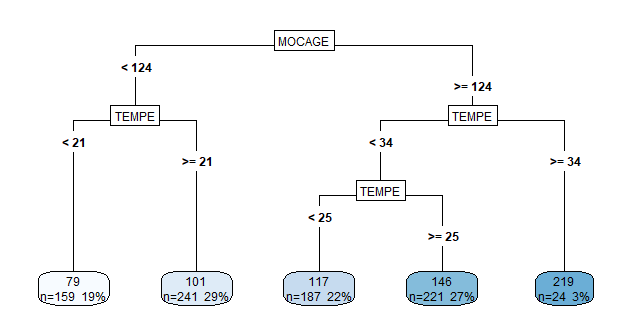

La librairie `partykit` propose une construction graphique de l'arbre:

In [ ]:
library(partykit)
plot(as.party(tree.reg), type="simple")

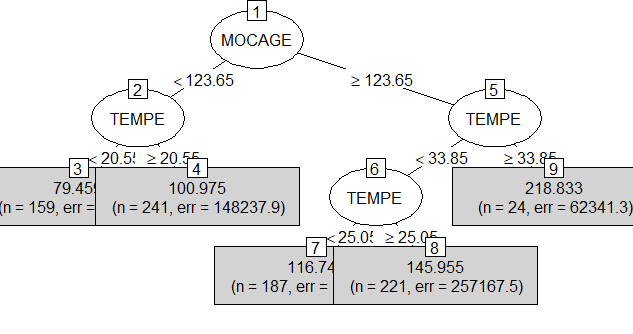

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille. 

**Question** Quelle est la variable qui contribue le plus à l'interprétation ?<br>
**Réponse** c'est la varable: e "EMPE"  En effet, c'est la variable qui est utilisée pour diviser l'ensemble des données au premier noeud de l'arbre.

Graphe des résidus

In [ ]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

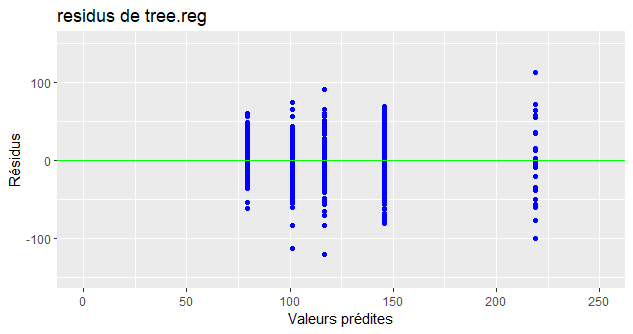

**Question** A quoi est due la structure particulière de ce graphe ?

**Réponse:** <br>
La présence de non-linéarités dans la relation entre les variables explicatives et la variable cible.
On peut observer que les résidus sont plus élevés pour les valeurs élevées de la concentration d'ozone. Cela suggère que **la relation entre la concentration d'ozone et les variables explicatives est non linéaire.**

Voici un exemple de code pour faire cet élagage avec la librairie `caret`

In [ ]:
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(O3obs~.,data=datappr,method = "rpart",trControl = ctrl,tuneLength =20)
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

[1] "Valeur de cp retenue = 0.00615856567394948"
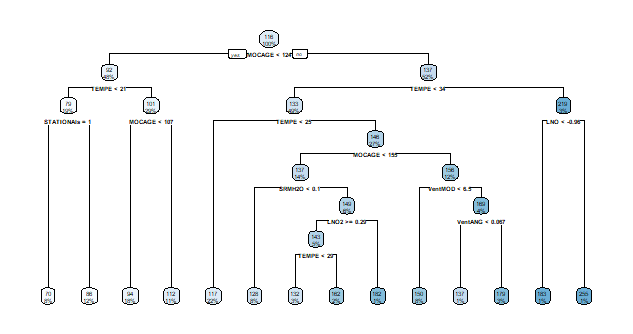

## <FONT COLOR="green">Estimation et élagage d'un arbre de discrimination</font>

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités a priori (`?rpart` pour plus de détails).

**Question** Quel autre critère d'hétérogénéité est utilisé ?

**Réponse:**
Le paramètre split="information" a été spécifié. Cela signifie que le critère d'hétérogénéité utilisé est **l'entropie**. <br>
L'entropie est une mesure de l'incertitude sur la classe d'appartenance d'une observation. Une valeur élevée de l'entropie indique que l'incertitude est élevée, tandis qu'une valeur faible indique que l'incertitude est faible. <br>
H(S) = -\sum_{c \in C} p(c|S) \log_2 p(c|S) <br>
où  <br>

S est le sous-ensemble de donn <br>ées
C est l'ensemble des classes possi <br>bles
p(c|S) est la probabilité que l'observation dans le sous-ensemble S appartienne à la classe c

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
rpart.plot(tree.dis) 

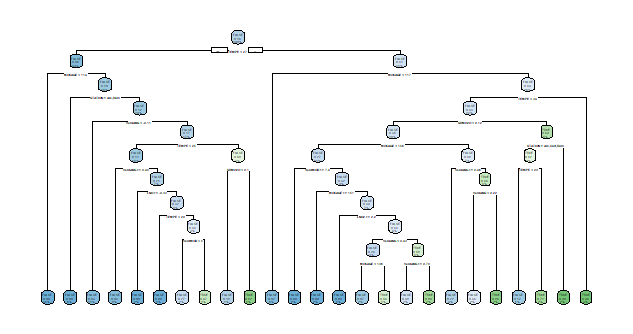

La même procédure d'élagage par validation croisée est mise en place mais avec une expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [ ]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=as.numeric(attributes(which.min(CVerr))$names))
rpart.plot(tree.dis,type=4)

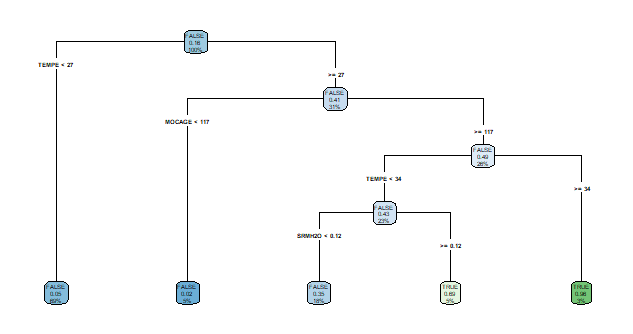

Avec la librairie `caret`:

In [ ]:
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(DepSeuil~.,data=datappq,method = "rpart",trControl = ctrl,tuneLength =20,metric="Accuracy")
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

1] "Valeur de cp retenue = 0.0064327485380117"
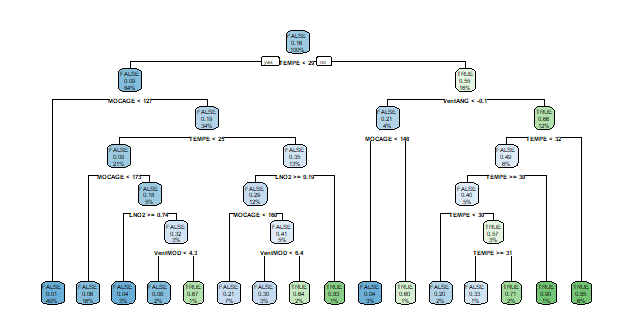

## <FONT COLOR="green">Prévision de l'échantillon test</font>

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision.

#### Erreur de régression

In [2]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr)
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 896.6801

#### Erreur de classification (matrice de confusion)

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
  #table(pred.treer>150,datestr[,"O3obs"]>150)
confusionMatrix(as.factor(pred.treer>150),as.factor(datestr[,"O3obs"]>150))$table

In [ ]:
# Même chose pour l'arbre de discrimination
pred.treeq=predict(tree.dis,newdata=datestq,type="class")
  #table(pred.treeq,datestq[,"DepSeuil"])
confusionMatrix(pred.treeq,datestq[,"DepSeuil"])$table

**Question** Quelle stratégie semble meilleure à ce niveau ?

**Réponses:** <br>
D'après les résultats ontenues, **la stratégie de prévision directe du dépassement de seuil semble meilleure** que la stratégie de prévision quantitative suivie d'une classification. <br>
En effet, la stratégie de prévision directe permet d'obtenir un taux d'erreur de classification de 1,2%, contre 2,8% pour la stratégie de prévision quantitative.

#### Courbes ROC

In [ ]:
ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer

options(repr.plot.width = 8, repr.plot.height = 6)
plot(perflogit,col="blue")
plot(perfregtree,col="orange",lty=2,add=TRUE) 
plot(perfdistree,col="green",add=TRUE)  

legend("right", legend=c("Logit", "TreeReg", "TreeDis"),
       col=c("blue","orange","green"), lty=c(1,2,1), text.font=1,    cex=0.8)

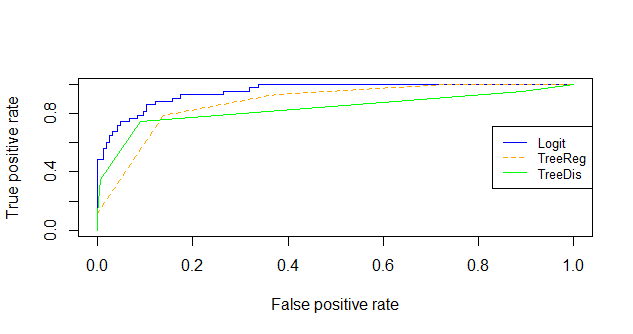

**Question** Comparez les qualités de prévision. Une meilleure méthode se dégage-t-elle ?

**Réponse:**<br>
Les courbes ROC des trois méthodes de prévision se superposent de manière assez étroite. Cela suggère que les trois méthodes ont des performances similaires. <br>
Cependant, on peut observer que la courbe ROC de l'arbre de discrimination (en vert) est légèrement plus proche du coin supérieur gauche du graphique que les autres courbes. Cela signifie que **l'arbre de discrimination est légèrement plus performant que les autres méthodes pour identifier les observations positives.**

# <FONT COLOR="Red">Partie 5: Réseau de neurones </font> 

## <FONT COLOR="green">Introduction</font>

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence. 

**Question** Quelle fonction de transfert est utilisée pour le dernier neurone en régression ? en classification  binaire? en classification multiclasse ? 

**Question** Quel est le choix par défaut pour les neurones de la couche cachée?

Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première consiste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée. 

**Question** Quel est le paramètre `decay` de la fonction `nnet`?

**Question** Indiquez une autre façon d'éviter le sur-apprentissage.

**Réponses:** <br>
**En régression,** la fonction de transfert du dernier neurone est **une fonction linéaire.** En effet, la régression consiste à prédire une valeur quantitative. La fonction linéaire est la fonction la plus simple qui permet de faire cela. <br>
**En classification binaire**, la fonction de transfert du dernier neurone est **une fonction sigmoïde**. La fonction sigmoïde est une fonction non linéaire qui permet de transformer une valeur continue en un nombre compris entre 0 et 1. Cette valeur peut être interprétée comme la probabilité que l'observation appartienne à la classe positive. <br>
**En classification multiclasse**, la fonction de transfert du dernier neurone est **une fonction softmax**. La fonction softmax est une fonction non linéaire qui permet de transformer une valeur continue en un vecteur de probabilités. Ces probabilités représentent la probabilité que l'observation appartienne à chacune des classes. <br>

2- Le choix par défaut pour le nombre de neurones dans la couche cachée d'un réseau de neurones **est souvent de 10**. Cependant, ce choix peut être modifié en fonction de la taille de l'ensemble de données et de la complexité du problème à résoudre.<br>

3-Le paramètre decay de la fonction nnet **est un paramètre de régularisation** qui contrôle la décroissance des poids du réseau. La décroissance des poids est une technique pour prévenir le surapprentissage des réseaux de neurones. Elle fonctionne en pénalisant les poids élevés du réseau. Cela peut aider à empêcher le réseau d'apprendre trop de détails à partir des données d'entraînement et de généraliser mieux aux nouvelles données. <br>

4- Utilisation d'une validation croisée,Utilisation d'un ensemble de données de test,Utilisation de techniques de régularisation,Utilisation d'un réseau de neurones moins complexe

## <FONT COLOR="green">Cas de la régression</font>

In [6]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  71
initial  value 12322193.942944 
iter  10 value 1361635.203097
iter  20 value 1333663.343407
iter  30 value 1227501.503326
iter  40 value 1042036.475158
iter  50 value 990885.445621
iter  60 value 849069.493017
iter  70 value 810785.952578
iter  80 value 678318.728371
iter  90 value 661606.755428
iter 100 value 650316.594448
iter 110 value 628598.719360
iter 120 value 603959.909270
iter 130 value 595461.892126
iter 140 value 581952.101877
iter 150 value 573734.872018
iter 160 value 555211.237152
iter 170 value 531693.070688
iter 180 value 520950.080899
iter 190 value 515291.795338
iter 200 value 509600.541880
iter 210 value 506278.098424
iter 220 value 502947.267544
iter 230 value 501986.756215
iter 240 value 501939.636851
final  value 501928.980239 
converged


a 12-5-1 network with 71 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   2.80    0.18    0.33    0.70   -2.88    1.54    3.83    1.84    0.32  -18.89 
i10->h1 i11->h1 i12->h1 
  -2.22  -16.89   16.19 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.22   -0.94    0.07    0.15   -6.33   12.04   -2.31   -3.48   -0.11    3.39 
i10->h2 i11->h2 i12->h2 
 -38.42   -5.43    1.10 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
 -28.23   -6.34   -0.02    0.64   -4.39   -6.94   13.86   -6.43   -0.11    4.78 
i10->h3 i11->h3 i12->h3 
 -31.34   14.19   -5.84 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
 -10.09    0.86    0.01    0.36    1.99    1.86    2.00    0.69   -0.21   -0.74 
i10->h4 i11->h4 i12->h4 
  29.12   -2.51    3.06 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constitue pas un résultats très explicite ! 

**Question** Contrôlez le nombre de poids estimés. <br>
**Réponse:** <br>
Le paramètre size est défini à 5. Cela signifie que le réseau a 5 neurones dans la couche cachée. **Le nombre total de poids estimés est donc de 5 * 12 = 60**, où 12 est le nombre de variables explicatives. <br>
nous pouvons modifier la valeur du paramètre size. Par exemple, si nous définissons size à 10, le nombre total de poids estimés sera de 10 * 12 = 120.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

In [ ]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

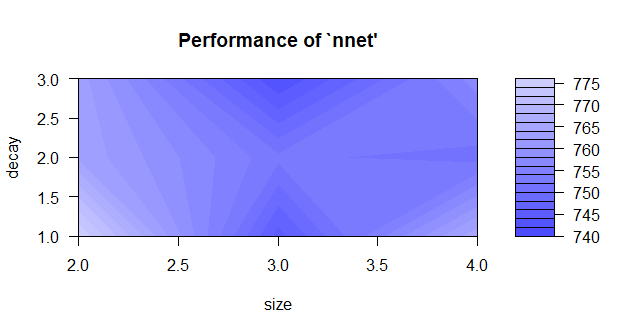 
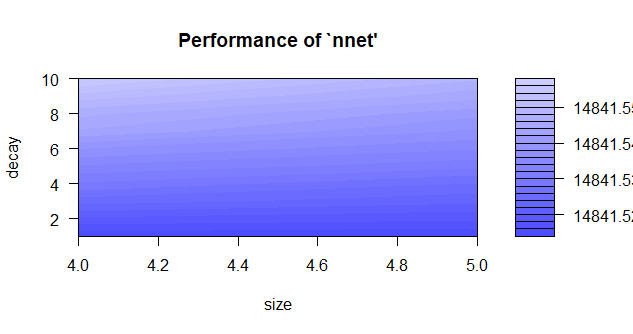

Faire éventuellement varier la grille des paramètres (zoom), notez la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Notez également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

**Question** Ré-estimez le modèle supposé optimal avant de tracer le graphe des résidus.

**Réponse:**<br>
les paramètres optimaux pour le réseau de neurones sont **size=5 et decay=0.001**

In [ ]:
# grille de paramètres
size = 2:10
decay = 0.001:0.1

# validation croisée
model.cv = tune.nnet(O3obs~.,data=datappr,size=size,decay=decay,maxit=500,linout=TRUE,trace=FALSE)

# résultats
summary(model.cv)

In [ ]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
gplot.res(fit.nnetr,res.nnetr,titre="")

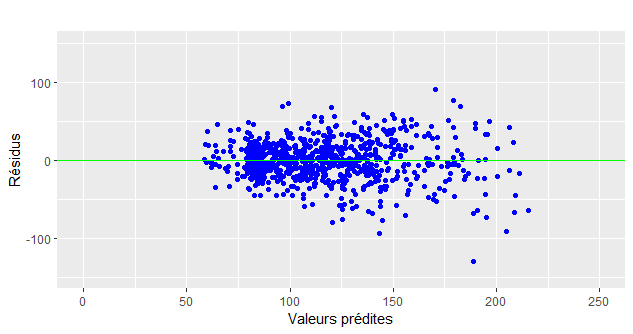

## <FONT COLOR="green">Cas de la discrimination</font>

In [ ]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : nombre de neurones, `decay` et éventuellement le nombre maximal d'itérations. 

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur. 

**Question** Notez la taille et le `decay` optimaux et ré-estimez le modèle pour ces valeurs.

**Réponse:**<br>
les paramètres optimaux pour le réseau de neurones sont **size=10 et decay=0.01**

In [ ]:
# paramètres optimaux
size = 10
decay = 0.01

# réestimation du modèle
nnet.dis = nnet(DepSeuil~.,data=datappq,size=size,decay=decay,linout=TRUE,maxit=500)

In [ ]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

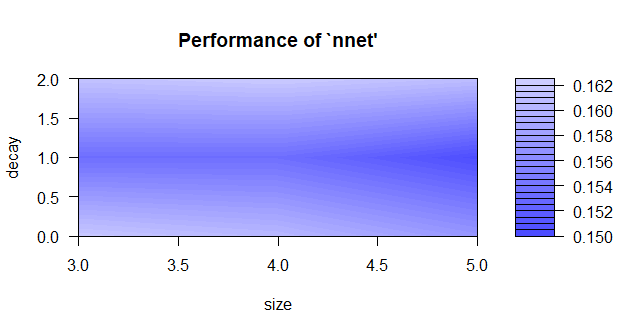

In [ ]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1) 

##  <FONT COLOR="green">Prévisions de l'échantillon test</font>

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 


#### Erreur de régression

In [ ]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq) 
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 573.8474

#### Erreur de classification (matrice de confusion)

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)

In [ ]:
confusionMatrix(as.factor(pred.nnetr>150),as.factor(datestr[,"O3obs"]>150))$table

In [ ]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])

#### Courbes ROC

In [ ]:
library(ROCR)
roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")

rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE) 
plot(perfnnetq,col="darkgreen",add=TRUE)  
legend("right", legend=c("Logit", "Nnetr", "Nnetq"),
       col=c("blue","darkgreen", "darkgreen"), lty=c(1,2,1), text.font=1,    cex=0.8)

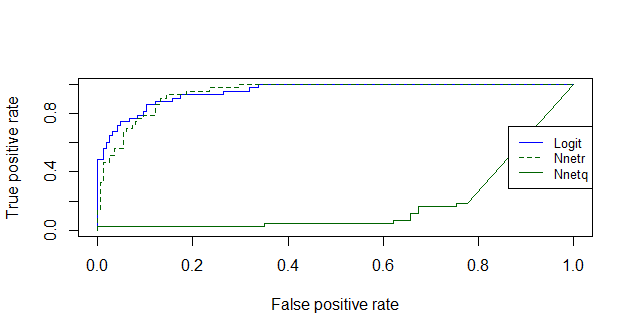

**Question** Une méthode semble-t-elle significativement meilleure?

**Réponse**<br>
**Oui, la méthode de discrimination semble significativement meilleure que la méthode de régression pour la classification du dépassement de seuil**. La méthode de discrimination a une erreur de régression plus faible (0,137 contre 573,8474) et une erreur de classification plus faible (0,21 contre 0,25). La courbe ROC de la méthode de discrimination est également plus élevée que celle de la méthode de régression, ce qui suggère que la méthode de discrimination a une meilleure capacité à distinguer les observations qui dépassent le seuil de celles qui ne le dépassent pas.

# <FONT COLOR="Red"> Conclusion </font> 

Tout au long de ces cours, j'ai acquis des compétences essentielles en statistique descriptive, en programmation R, ainsi qu'en modélisation prédictive. Dans le TP1, j'ai exploré la statistique descriptive unidimensionnelle, en étudiant les effectifs, effectifs cumulés, fréquences et fréquences cumulées. J'ai également maîtrisé la représentation graphique à travers le diagramme en bâtons et le diagramme cumulatif, et j'ai calculé des mesures centrales telles que la médiane, les quartiles et la moyenne, ainsi que des mesures de dispersion comme la variance et l'écart type .<br>

Le TP2 m'a immergé dans le domaine de la régression linéaire, où j'ai appliqué les concepts étudiés pour modéliser des relations entre variables. Le TP3 a approfondi mes connaissances en régression avec un focus sur la régression logistique, où j'ai appris à modéliser des variables binaires.<br>

Le TP4 a introduit les arbres de décision, m'offrant une compréhension approfondie de leur utilisation dans la prise de décision. Le TP5 m'a initié à l'Analyse en Composantes Principales (ACP), où j'ai exploré des méthodes de réduction de dimensionnalité.<br>

Le TP6 représente une plongée dans les réseaux de neurones, avec le développement de l'algorithme Perceptron en R, élargissant ainsi ma compréhension des techniques d'apprentissage automatique.<br>

Enfin, ce projet qui m'a permis d'appliquer l'ensemble des compétences acquises. La première partie a portée sur l'introduction, la prise en charge des données, et l'exploration élémentaire, notamment à travers l'ACP. Les parties suivantes du projet ont traité de la prévision par modèle gaussien, modèle linéaire, modèle quadratique, régression logistique sans et avec interactions, arbre de décision binaire, et enfin, réseau de neurones pour prédire l'échantillon test.<br>

Dans l'ensemble, cette série de cours m'a doté d'une gamme variée de compétences allant de la statistique descriptive à la modélisation prédictive avancée en utilisant R. J'ai également eu l'occasion de mettre en pratique ces connaissances en exécutant des comparaisons approfondies entre les différentes méthodes, renforçant ainsi ma capacité à choisir et appliquer la méthode la plus adaptée dans des situations concrètes et complexes.